#### Z2 HIGGS MODEL
$$
\hat{H}_{\text{Z2}} = -g \sum_{i=1}^{L-1} \hat{X}_{i,i+1} + U \sum_{i=1}^{L} \hat{n}_i^2 - J \sum_{i=1}^{L-1} \left( \hat{a}_i^\dagger \hat{Z}_{i,i+1} \hat{a}_{i+1} + \text{h.c.} \right),
$$

For $L=2$ sites this is $\hat{H}_{\text{Z2}} = -g \hat{X}_{1,2} + U\left(\hat{n}_1^2 + \hat{n}_2^2\right) - J\left(\hat{a}_1^\dagger \hat{Z}_{1,2} \hat{a}_2 + \hat{a}_2^\dagger \hat{Z}_{1,2} \hat{a}_1\right)$. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2
from scipy.sparse import csr_matrix, kron

import sys
from pathlib import Path

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
sys.path.append(str(playground_path))
# Homemade functions
from bosonic_operator_costs.all_qubit_utils import create_annihilation_operator, create_creation_operator, simulate_system

In [ ]:
import numpy as np
from bosonic_operator_costs.all_qubit_utils import create_annihilation_operator, create_creation_operator

# Pauli matrices
X = np.array([[0, 1], [1, 0]])  # Pauli-X
Z = np.array([[1, 0], [0, -1]])  # Pauli-Z
I = np.eye(2)  # Identity matrix

def create_number_operator(n_max):
    """Create the number operator for a single mode."""
    return np.diag(np.arange(n_max))

def X_term_link(n_max, g):
    """
    Construct the term -g * X_{1,2}.
    """
    X_12 = np.kron(np.kron(np.eye(n_max + 1), X), np.eye(n_max + 1))  # (I_site ⊗ X_link ⊗ I_site)
    return -g * X_12

def n_squared_term_sites(n_max, U):
    """
    Construct the term U * (n_1^2 + n_2^2).
    """
    n_squared = create_number_operator(n_max+1) ** 2
    n_1_squared = np.kron(np.kron(n_squared, np.eye(2)), np.eye(n_max + 1))  # (n_1^2 ⊗ I_link ⊗ I_site)
    n_2_squared = np.kron(np.kron(np.eye(n_max + 1), np.eye(2)), n_squared)  # (I_site ⊗ I_link ⊗ n_2^2)
    return U * (n_1_squared + n_2_squared)


def hopping_term(n_max, J):
    """
    Construct the hopping term -J * (a_1^† Z_{1,2} a_2 + h.c.) in a 1+1D system.
    """
    # Creation and annihilation operators
    a = create_annihilation_operator(n_max)
    a_dag = create_creation_operator(n_max)

    # Identity matrices
    I_site = np.eye(n_max + 1)  # Site Hilbert space (dimension n_max + 1)
    I_link = np.eye(2)          # Link Hilbert space (dimension 2)

    # Operators for site 1
    a_1 = np.kron(np.kron(a, I_link), I_site)  # (a_1 ⊗ I_link ⊗ I_site)
    a_1_dag = np.kron(np.kron(a_dag, I_link), I_site)  # (a_1^† ⊗ I_link ⊗ I_site)

    # Operators for site 2
    a_2 = np.kron(np.kron(I_site, I_link), a)  # (I_site ⊗ I_link ⊗ a_2)
    a_2_dag = np.kron(np.kron(I_site, I_link), a_dag)  # (I_site ⊗ I_link ⊗ a_2^†)

    # Z2 gauge field operator on the link
    Z_12 = np.kron(np.kron(I_site, np.array([[1, 0], [0, -1]])), I_site)  # (I_site ⊗ Z ⊗ I_site)

    # Hopping term
    hopping = -J * (a_1_dag @ Z_12 @ a_2 + a_2_dag @ Z_12 @ a_1)

    return hopping

def z2_higgs_hamiltonian(n_max, g, U, J):
    """
    Construct the full Z2 Higgs Hamiltonian for two sites.
    """
    # Combine terms
    H = X_term_link(n_max, g) + n_squared_term_sites(n_max, U) + hopping_term(n_max, J)
    return H

In [3]:
def define_initial_state(num_modes, n_max, additional_qubits):
    """
    Define the initial state vector for the system.

    Parameters:
        n_qubits (int): The number of qubits in the system.

    Returns:
        Statevector: The initial quantum state.
    """
    n_qubits = num_modes * int(np.ceil(np.log2(n_max + 1))) + additional_qubits
    initial_state_vector = np.zeros(2**n_qubits, dtype=complex)
    initial_state_vector[2] = 1.0

    return Statevector(initial_state_vector)

In [4]:
cutoffs = [2**n - 1 for n in range(1, 6)]
num_modes = 2  
additional_qubits = 1

g = 0.5
U = 1
J = 1

# Initialize lists to store results
rz_gates = []
cnot_gates = []
total_gates = []
total_depths = []
rotation_gate_depths = []
cnot_gate_depths = []

# Loop through each cutoff and simulate the system
for n_max in cutoffs:
    #Hamiltonian and state for current cutoff
    hamiltonian = z2_higgs_hamiltonian(n_max, g, U, J) 
    state = define_initial_state(num_modes, n_max, additional_qubits)

    # Simulate the system and collect results
    results = simulate_system(
        hamiltonian=hamiltonian,
        initial_state=state,
        num_modes=num_modes,
        n_max=n_max
    )
    # Collect gate counts and depths
    rz_gates.append(results["gate_counts"].get('rz', 0))
    cnot_gates.append(results["gate_counts"].get('cx', 0))
    total_gates.append(sum(results["gate_counts"].values()))
    total_depths.append(results["total_depth"])
    rotation_gate_depths.append(results["rz_depth"])
    cnot_gate_depths.append(results["cnot_depth"])

CNOT Gates Scaling: k=9.39, n=2.57
Rotation Gates Scaling: k=8.72, n=2.50
CNOT Depth Scaling: k=9.37, n=2.57
Rotation Gate Depth Scaling: k=6.35, n=2.53


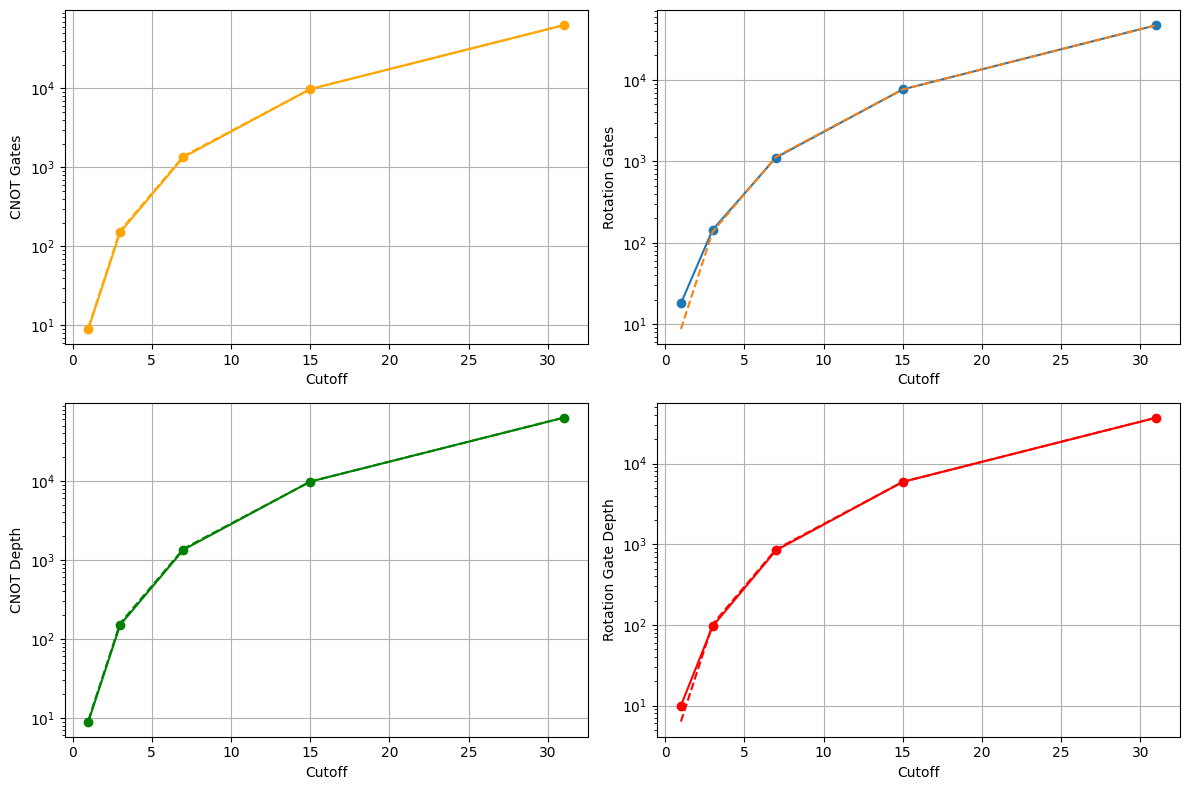

In [5]:
from scipy.optimize import curve_fit

# Plot labels and data
plots = [
    {"y": cnot_gates, "label": "CNOT Gates", "color": "orange", "ylabel": "CNOT Gates"},
    {"y": rz_gates, "label": "Rotation Gates", "color": None, "ylabel": "Rotation Gates"},
    {"y": cnot_gate_depths, "label": "CNOT Depth", "color": "green", "ylabel": "CNOT Depth"},
    {"y": rotation_gate_depths, "label": "Rotation Gate Depth", "color": "red", "ylabel": "Rotation Gate Depth"},
]
# Define power law function for fitting
def power_law(x, k, n):
    return k * x**n

# Create subplots
plt.figure(figsize=(12, 8))

for i, plot in enumerate(plots, 1):
    y_data = plot["y"]
    
    # Perform curve fitting
    params, _ = curve_fit(power_law, cutoffs, y_data)
    k, n = params
    
    # Print scaling parameters for each dataset
    print(f"{plot['label']} Scaling: k={k:.2f}, n={n:.2f}")
    
    # Plot original data and fit
    plt.subplot(2, 2, i)
    plt.plot(cutoffs, y_data, 'o-', label=f"{plot['label']} Data", color=plot["color"])
    plt.plot(cutoffs, power_law(cutoffs, *params), '--', 
         label=f"Fit: $y = {k:.2f}x^{{{n:.2f}}}$", color=plot["color"]) 
    plt.yscale('log')  # Set log scale

    plt.xlabel("Cutoff")
    plt.ylabel(plot["ylabel"])
    plt.grid()
    # plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()